In [19]:
import gymnasium as gym
import numpy as np
import shutil

In [20]:
gravity = -10
wind_power = 0
turbulence_power = 0

In [21]:
discrete_options = 12

class QLearningAgent:
    def __init__(
            self,
            env,
            learning_rate=0.01,
            discount_factor=0.9,
            exploration_rate=1.0,
            epsilon_decay=0.9999,
    ):
        self.env = env
        self.alpha = learning_rate
        self.discount = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = epsilon_decay
        self.qValues = np.zeros((discrete_options, discrete_options, discrete_options, discrete_options, discrete_options, discrete_options, discrete_options, discrete_options, env.action_space.n))

    def getQIndex(self, state):
        # Turn the state into values from 0 to 1 depending on the min and max of the state
        state_adj = (state - self.env.observation_space.low) / (self.env.observation_space.high - self.env.observation_space.low)

        # Round the state to the nearest discrete option
        state_discrete = np.round(state_adj * (discrete_options - 1)).astype(int)
        return tuple(state_discrete)


    def getQValue(self, state, action):
        return self.qValues[self.getQIndex(state)][action]
    
    def setQValue(self, state, action, value):
        self.qValues[self.getQIndex(state)][action] = value
    
    def bestAction(self, state):
        return np.argmax(self.qValues[self.getQIndex(state)])
    
    def bestQValue(self, state):
        return np.max(self.qValues[self.getQIndex(state)])
    
    def nextAction(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.bestAction(state)
        
    def update(self, state, action, reward, nextState):
        currentQValue = self.getQValue(state, action)
        maxQValue = self.bestQValue(nextState)
        newUtility = reward + self.discount * maxQValue

        self.setQValue(state, action, (1 - self.alpha) * currentQValue + self.alpha * newUtility)

    def decayEpsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.4)

In [22]:
class ApproxQLearningAgent:
    def __init__(
            self,
            env,
            learning_rate=0.01,
            discount_factor=0.9,
            exploration_rate=1.0,
            epsilon_decay=0.9999,
    ):
        self.env = env
        self.alpha = learning_rate
        self.discount = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = epsilon_decay
        # self.weights = np.random.rand(7)
        self.weights = np.array([0, 0, 0, -10, -50, 0, 0]).astype(float)
        self.training = True


    def featureExtractor(self, state, action):

        x, y, vx, vy, angle, ang_vel, left_leg, right_leg = state

        # Predicted state
        time = 0.002
        angular_thrust = 15
        horizontal_thrust = 25
        vertical_thrust = 25

        if action == 1: # left orientation engine
            ang_vel += time * angular_thrust # Angular velocity
        elif action == 3: # right orientation engine
            ang_vel -= time * angular_thrust # Angular velocity
        elif action == 2: # main engine
            vertical_thrust *= np.cos(angle)
            horizontal_thrust *= np.sin(angle)
            vx += time * horizontal_thrust # x-velocity
            vy += time * vertical_thrust # y-velocity

        vy += time * gravity
        x += time * vx
        y += time * vy
        angle += time * ang_vel


        features = np.array([
            1, 
            abs(x),
            y,
            abs(vy + y * 0.7),
            abs(angle - x * 0.5),
            abs(ang_vel - (vx) * 0.3),
            abs(ang_vel)
        ]).astype(float)

        return features


    def getQValue(self, state, action):
        features = self.featureExtractor(state, action)
        value = 0
        for i in range(len(features)):
            value += self.weights[i] * features[i]
        return value
    
    def bestAction(self, state):
        x, y, vx, vy, angle, ang_vel, left_leg, right_leg = state
        if abs(x) < 0.1 and abs(y) < 0.1 and abs(vx) < 0.1 and abs(vy) < 0.1 and left_leg and right_leg:
            return 0
        
        best_action = 0
        best_value = float('-inf')
        for action in range(4):
            value = self.getQValue(state, action)
            if not self.training:
                print("Action:", action, "Value:", value)
            if value > best_value:
                best_value = value
                best_action = action
        return best_action
    
    def bestQValue(self, state):
        best_value = float('-inf')
        for action in range(4):
            value = self.getQValue(state, action)
            if value > best_value:
                best_value = value
        return best_value
    
    def nextAction(self, state):
        return self.bestAction(state)
        
    def update(self, state, action, reward, nextState):

        features = self.featureExtractor(state, action)

        currentQValue = self.getQValue(state, action)
        maxNextQValue = self.bestQValue(nextState)
        difference = (reward + self.discount * maxNextQValue) - currentQValue

        for i in range(len(features)):
            self.weights[i] += self.alpha * difference * features[i]


    def decayEpsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01)

In [23]:
env1 = gym.make("LunarLander-v3", continuous=False, gravity=gravity,
               enable_wind=False, wind_power=wind_power, turbulence_power=turbulence_power, render_mode="rgb_array")
env2 = gym.make("LunarLander-v3", continuous=False, gravity=gravity,
               enable_wind=False, wind_power=wind_power, turbulence_power=turbulence_power, render_mode="rgb_array")

In [24]:
agent1 = QLearningAgent(env1)
agent2 = ApproxQLearningAgent(env2)

In [25]:
episodes1 = 5000
episodes2 = 5000

recordings_count = 20
env1 = gym.wrappers.RecordVideo(env1, video_folder="output_videos", name_prefix="q_learning", episode_trigger=lambda x: x % (episodes1 // recordings_count) == 0)
env2 = gym.wrappers.RecordVideo(env2, video_folder="output_videos", name_prefix="approx_q_learning", episode_trigger=lambda x: x % (episodes2 // recordings_count) == 0)

env1 = gym.wrappers.RecordEpisodeStatistics(env1, buffer_length=episodes1)
env2 = gym.wrappers.RecordEpisodeStatistics(env2, buffer_length=episodes2)

shutil.rmtree("output_videos", ignore_errors=True)
shutil.os.makedirs("output_videos", exist_ok=True)

c:\Users\moyer\OneDrive\Documents\repos\q-learning-project\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\moyer\OneDrive\Documents\repos\q-learning-project\output_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [954]:

def train(env, agent, episodes, name):

    ave_reward = 0
    for episode in range(1, episodes+1):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.nextAction(state)
            nextState, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, nextState)

            state = nextState
            total_reward += reward

        ave_reward += total_reward

        if episode % 500 == 0:
            print(f"{name} - Episode {episode}/{episodes}, Average Total Reward: {ave_reward/500}, Epsilon: {agent.epsilon:.4f}")
            ave_reward = 0
        agent.decayEpsilon()

train(env1, agent1, episodes1, "Q-Learning")
train(env2, agent2, episodes2, "Approximate Q-Learning")

Q-Learning - Episode 500/5000, Average Total Reward: -176.8715378123226, Epsilon: 0.9513
Q-Learning - Episode 1000/5000, Average Total Reward: -166.3009978563238, Epsilon: 0.9049
Q-Learning - Episode 1500/5000, Average Total Reward: -151.57643311039328, Epsilon: 0.8608
Q-Learning - Episode 2000/5000, Average Total Reward: -140.3530030066458, Epsilon: 0.8188
Q-Learning - Episode 2500/5000, Average Total Reward: -127.10968357680761, Epsilon: 0.7789
Q-Learning - Episode 3000/5000, Average Total Reward: -116.75552620153499, Epsilon: 0.7409
Q-Learning - Episode 3500/5000, Average Total Reward: -105.16368510970896, Epsilon: 0.7047
Q-Learning - Episode 4000/5000, Average Total Reward: -101.47939527796301, Epsilon: 0.6704
Q-Learning - Episode 4500/5000, Average Total Reward: -92.79266563938192, Epsilon: 0.6377
Q-Learning - Episode 5000/5000, Average Total Reward: -96.73760593401056, Epsilon: 0.6066
Approximate Q-Learning - Episode 500/5000, Average Total Reward: 76.96333422325282, Epsilon: 0.9

c:\Users\moyer\OneDrive\Documents\repos\q-learning-project\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Approximate Q-Learning - Episode 1500/5000, Average Total Reward: 103.70611701394321, Epsilon: 0.8608
Approximate Q-Learning - Episode 2000/5000, Average Total Reward: 112.3674109647631, Epsilon: 0.8188
Approximate Q-Learning - Episode 2500/5000, Average Total Reward: 96.33678438871219, Epsilon: 0.7789


KeyboardInterrupt: 

In [955]:
print(agent2.weights)

[  6.9170346   -8.72525746   6.41264449 -17.77655115 -20.39673468
  -8.11386926  -8.28454858]


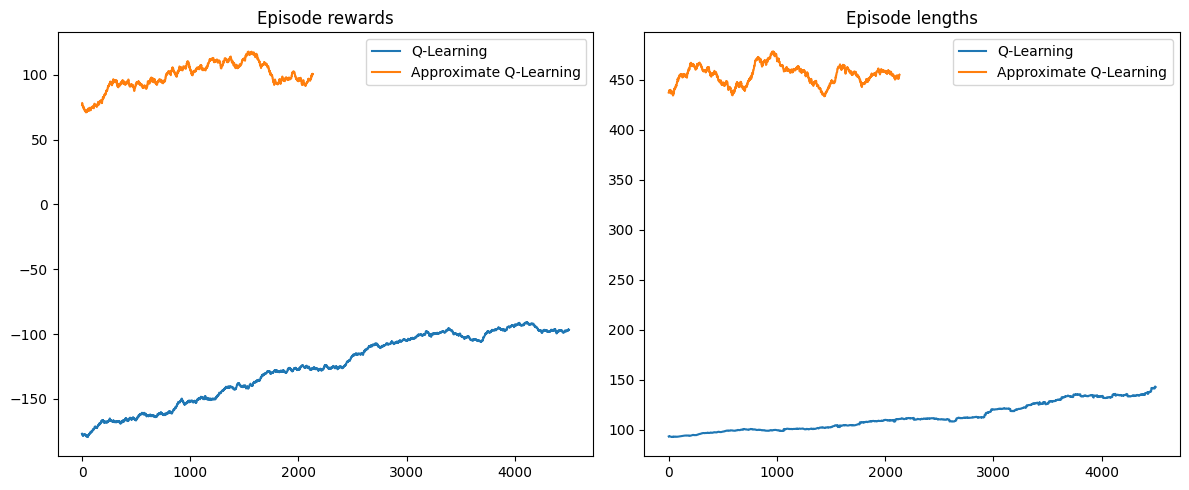

In [956]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the moving average of the rewards
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env1.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average, label='Q-Learning')

reward_moving_average = get_moving_avgs(
    env2.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average, label='Approximate Q-Learning')

# Add legend to the rewards plot
axs[0].legend()


# Plot the moving average of the episode lengths
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env1.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average, label='Q-Learning')

length_moving_average = get_moving_avgs(
    env2.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average, label='Approximate Q-Learning')

# Add legend to the episode lengths plot
axs[1].legend()

plt.tight_layout()
plt.show()

In [936]:
env = gym.make("LunarLander-v3", continuous=False, gravity=gravity,
               enable_wind=False, wind_power=wind_power, turbulence_power=turbulence_power)

In [939]:
# agent2.training = False
ave_reward = 0
for i in range(1000):
    observation, info = env.reset()
    episode_over = False
    total_reward = 0
    actions = 0
    while not episode_over:
        action = agent2.bestAction(observation)
        # predicted = agent.featureExtractor(observation, action)
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        actions += 1
    ave_reward += total_reward
    # print(f"Episode {i+1} took {actions} actions and earned {total_reward} reward")

print(f"Average reward over 1000 episodes: {ave_reward/1000}")

Average reward over 1000 episodes: 188.0521986827196


In [27]:
env = gym.make("LunarLander-v3", continuous=False, gravity=gravity,
               enable_wind=False, wind_power=wind_power, turbulence_power=turbulence_power, render_mode="rgb_array")

env = gym.wrappers.RecordVideo(env, video_folder="example_videos", name_prefix="example", episode_trigger=lambda x: True)

In [28]:
high_score = 0
high_score_episode = 0

for i in range(100):
    observation, info = env.reset()
    episode_over = False
    total_reward = 0
    actions = 0
    while not episode_over:
        action = agent2.bestAction(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        actions += 1
    print(f"Episode {i+1} took {actions} actions and earned {total_reward} reward")
    if total_reward > high_score:
        high_score = total_reward
        high_score_episode = i

print(f"Highest score was {high_score} in episode {high_score_episode+1}")

Episode 1 took 450 actions and earned 241.0672372961301 reward
Episode 2 took 570 actions and earned 234.44276971768411 reward
Episode 3 took 369 actions and earned 205.4337623115821 reward
Episode 4 took 441 actions and earned 213.007126550582 reward
Episode 5 took 391 actions and earned 226.26523359557774 reward
Episode 6 took 510 actions and earned 233.22431036058637 reward
Episode 7 took 731 actions and earned 202.68534627500543 reward
Episode 8 took 359 actions and earned 176.6538880307295 reward
Episode 9 took 438 actions and earned 241.403726170298 reward
Episode 10 took 880 actions and earned 233.60723356586735 reward
Episode 11 took 599 actions and earned 181.4615647846865 reward
Episode 12 took 738 actions and earned 245.7574937032709 reward
Episode 13 took 524 actions and earned 229.01687157226422 reward
Episode 14 took 612 actions and earned 256.79936467027323 reward
Episode 15 took 426 actions and earned 242.0908726209452 reward
Episode 16 took 737 actions and earned 228.8

KeyboardInterrupt: 

In [466]:
env.close()